In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [2]:
def mask_filter_by_time(df, algorithms, max_runtime_s, prev_max_runtime_s=None):
    max_runtime_us = max_runtime_s * 1e6
    mask = df[algorithms[0] + ' runtime (micros)'] <= max_runtime_us
    for a in algorithms:
        mask = mask & (df[a + ' runtime (micros)'] <= max_runtime_us) 
    if prev_max_runtime_s is not None:
        mask = mask & (~mask_filter_by_time(df, algorithms, prev_max_runtime_s))
    return mask
    
def filter_by_time(df, algorithms, max_runtime_s, prev_max_runtime_s=None):
    return df[mask_filter_by_time(df, algorithms, max_runtime_s, prev_max_runtime_s)]

def filter_by_mtx(df, mtx):
    return df[df['Matrix'] == mtx]

def filter_by_size(df, min_size, max_size):
    return df[(df['Graph size'] <= max_size) & (df['Graph size'] >= min_size)]

def get_max_bounds(bounds):
    values = sorted(list(set(bounds)))
    max_value = values[-1] 
    almost_max_value = values[-2]
    for i in range(len(bounds)):
        if bounds[i] == max_value:
            bounds[i] = almost_max_value
    return bounds
    
    
def get_labels(names):
    labels = []
    for name in names:
        i1 = name.find('(')
        i2 = name.find(')')
        if i1 == -1:
            labels.append(name)
        elif i2 - i1 > 9:
            labels.append(name[:i1] + '\n' + name[i1:i2 - 3] + name[i2:])
        else:
            labels.append(name[:i1] + '\n' + name[i1:])
    return labels

def get_bounds(s):
    bounds = []
    for b in s.split():
        bounds.append(int(b))
    return bounds

def add_graph_size(df):
    sizes = []
    for sequences in df['Sequence lengths'].values:
        size = 1
        for l in sequences.split():
            size *= int(l)
        sizes.append(size)
    df.insert(2, 'Graph size', sizes)
    return df

In [3]:
plots_path = 'data/plots/'
if not os.path.exists(plots_path):
    os.makedirs(plots_path)

pea_weights = [30, 50, 70]
awa_weights = ['1.001000', '1.010101', '1.100000', '1.500000']
PAM = 'PAM250'

pea_names = [f'PEA*(c={w})' for w in pea_weights]
awa_names = [f'AnytimeA*(w={w})' for w in awa_weights]
all_names = ['PA', 'A*', 'IDA*'] + pea_names + awa_names

In [4]:
df = pd.read_csv("results.csv")
df = add_graph_size(df)
df_ida = filter_by_mtx(filter_by_time(df, all_names, 5), PAM) # ida was not interrupted
df_ida_small =  filter_by_size(df_ida, 0, 1e6)
df_ida_large = filter_by_size(df_ida, 1e6, 1e19)

df_other = filter_by_mtx(filter_by_time(df,['PA', 'A*'] + pea_names + awa_names, 5), PAM) # ida wasn't interrupted on any other algorithm
df_small = filter_by_size(df_other, 0, 1e6)
df_large = filter_by_size(df_other, 1e6, 1e19)

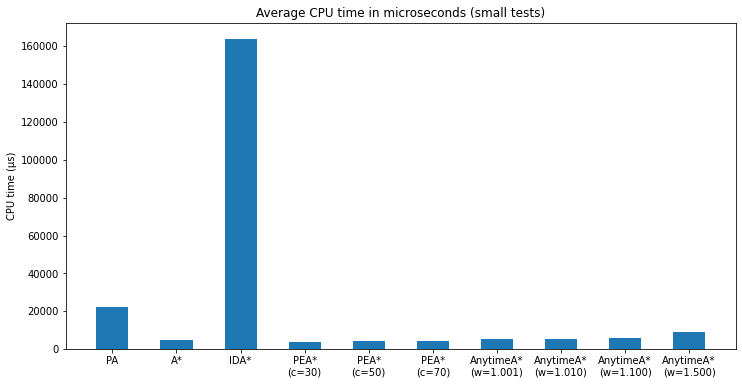

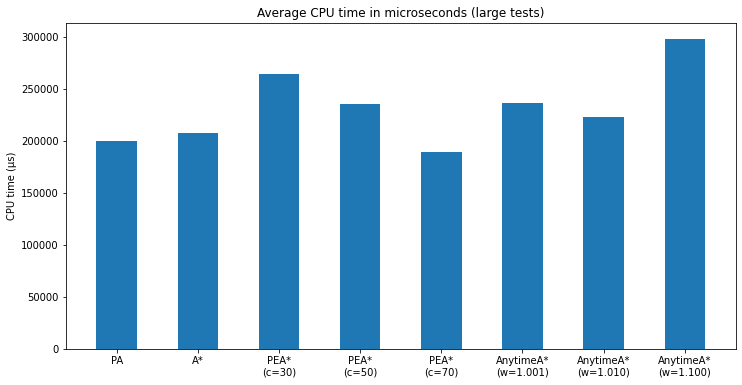

In [5]:
# with slowest algorithms
fig, ax = plt.subplots(figsize=(12,6))
df_cur = df_ida_small
labels = get_labels(all_names)
x = np.arange(len(labels))
y = [df_cur[a + ' runtime (micros)'].mean() for a in all_names]
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('CPU time (μs)')
ax.set_title('Average CPU time in microseconds (small tests)')
ax.bar(x, y, 0.5)
plt.savefig(plots_path + "cpu_small_tests.png")

#without slowest algorithms
fig, ax = plt.subplots(figsize=(12,6))
df_cur = df_large
names = ['PA', 'A*'] + pea_names + awa_names[:-1]
labels = get_labels(names)
x = np.arange(len(labels))
y = [df_cur[a + ' runtime (micros)'].mean() for a in names]
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('CPU time (μs)')
ax.set_title('Average CPU time in microseconds (large tests)')
ax.bar(x, y, 0.5)
plt.savefig(plots_path + "cpu_large_tests.png")

plt.show()

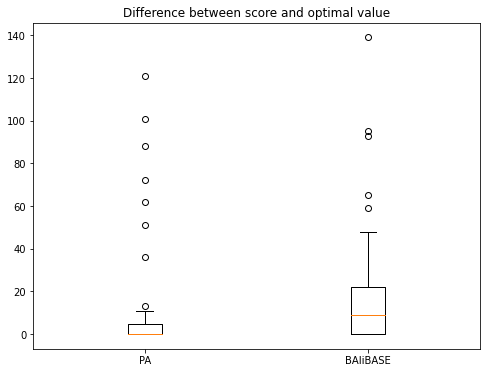

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
df_cur = df_small
names = ['PA', 'Real alignment']
labels = ['PA', 'BAliBASE']
y = [df_cur[a + ' score'] - df_cur['A* score']  for a in names]
ax.boxplot(y, labels=labels)
ax.set_title('Difference between score and optimal value')
plt.savefig(plots_path + "score_difference.png")

plt.show()

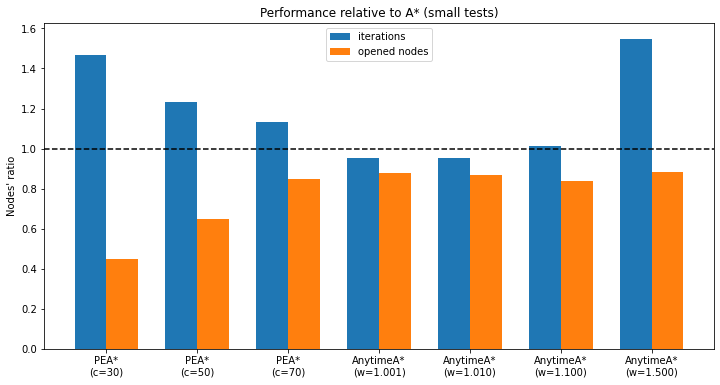

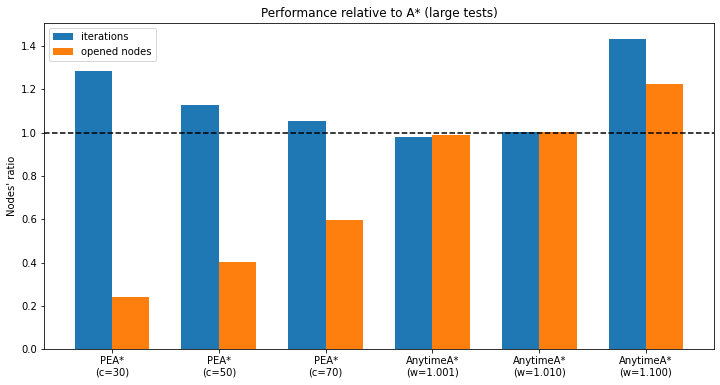

In [7]:
for i, (df_cur, test_type) in enumerate(zip([df_small, df_large], ['small tests', 'large tests'])):
    fig, ax = plt.subplots(figsize=(12,6))
    names = pea_names  + (awa_names if i == 0 else awa_names[:-1])
    labels = get_labels(names)
    x = np.arange(len(labels))
    y_time = [(df_cur[a + ' iterations'] / df_cur['A* iterations']).mean() for a in names]
    y_memory = [(df_cur[a + ' memory'] / df_cur['A* memory']).mean() for a in names]
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel('Nodes\' ratio')
    ax.set_title(f'Performance relative to A* ({test_type})')
    width = 0.35
    ax.axhline(y=1.0, color='black', linestyle='--')
    ax.bar(x - width / 2, y_time, width, label='iterations')
    ax.bar(x + width / 2, y_memory, width, label='opened nodes')
    ax.legend()
    plt.savefig(plots_path + f"performance_{test_type.replace(' ', '_')}.png")

plt.show()


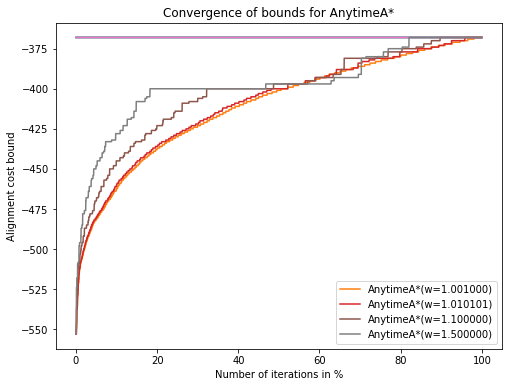

In [8]:
df_single = pd.read_csv("single_test_results.csv")

min_bounds_names = [a + ' min bounds' for a in awa_names]
max_bounds_names = [a + ' max bounds' for a in awa_names]

min_bounds = [get_bounds(df_single[a].values[0]) for a in min_bounds_names]
max_bounds = [get_bounds(df_single[a].values[0])for a in max_bounds_names]
max_bounds = [get_max_bounds(bounds) for bounds in max_bounds]
optimals = [df_single[a + ' score'].values[0] for a in awa_names]
fig, ax = plt.subplots(figsize=(8,6))

ax.set_title('Convergence of bounds for AnytimeA*')
ax.set_xlabel('Number of iterations in %')
ax.set_ylabel('Alignment cost bound')
for i, (y_min, y_max, a) in enumerate(zip(min_bounds, max_bounds, awa_names)):
    x = 100 * np.arange(len(y_min)) / len(y_min)
    ax.plot(x, y_max)
    ax.plot(x, y_min, label=a)
ax.legend()
plt.savefig(plots_path + "anytime_convergence.png")
plt.show()

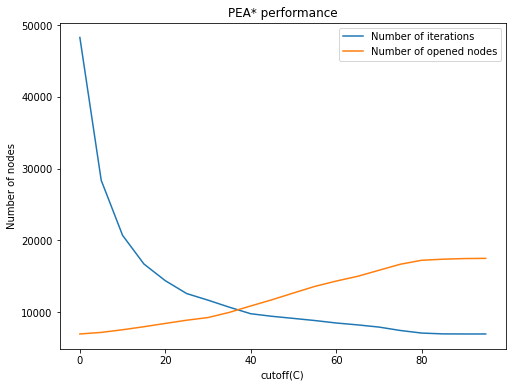

In [11]:
fig, ax = plt.subplots(figsize=(8,6))

pea_weights_single = [5 * i for i in range(20)]
names = [f'PEA*(c={w})' for w in pea_weights_single]
df_cur = df_small
x = pea_weights_single
y_time = [df_single[a + ' iterations'].values[0] for a in names]
y_memory = [df_single[a + ' memory'].values[0] for a in names]
ax.plot(x, y_time, label='Number of iterations')
ax.plot(x, y_memory, label='Number of opened nodes')
ax.set_ylabel('Number of nodes')
ax.set_title('PEA* performance')
ax.set_xlabel('cutoff(C)')
ax.legend()
plt.savefig(plots_path + "pea_cutoff.png")
plt.show()